# **Playing with Cirq**

Check if ```cirq``` is installed

In [1]:
!python -c 'import cirq_google; print(cirq_google.Sycamore)'

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

It works!

### **Hello Qubit**

In [2]:
import cirq

# pick a qubit
qubit = cirq.GridQubit(0, 0)

# create a circuit that applies a square root of NOT gate & measures the qubit
circuit = cirq.Circuit(cirq.X(qubit) ** 0.5, cirq.measure(qubit, key='m'))
print("Circuit: ")
print(circuit)

# simulate the circuit several times
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)
print("Results: ")
print(result)

Circuit: 
(0, 0): ───X^0.5───M('m')───
Results: 
m=00111001110000111010


### **Qubits**

To create a quantum circuit, first we must define a set of qubits/quantum registers to act on. 

We can define qubits by 3 ways:
- ```cirq.NamedQubit```: by an abstract name
- ```cirq.LineQubit```: by number in a linear array
- ```cirq.GridQubit```: by 2 numbers in a rectangular lattice

In [3]:
# named qubits for abstract algorithms & algorithms unmapped onto hardware
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# create line qubits individually
q3 = cirq.LineQubit(3)

# create line qubits in a range like LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# create grid qubits individually
q4_5 = cirq.GridQubit(4, 5)

# create grid qubits in bulk in a square (16) from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)

### **Gates & Operations**

Now we will create operations using qubits to be used in the circuit. 
- ```Gate``` is an effect that can be applied to a set of qubits.
- ```Operation``` is a gate applied to a set of qubits.

```cirq.H``` is a quantum Hadamard (fundamental quantum gate) which is a ```Gate``` object. ```cirq.H(cirq.LineQubit(1))``` is an ```Operation``` object which is the Hadamard gate applied to a specific qubit (line qubit number 1).

In [4]:
# example gates
cnot_gate = cirq.CNOT
pauli_z = cirq.Z

# use exponentiation to get square root gates
sqrt_x_gate = cirq.X**0.5

# some gates can also take parameters
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

# create two qubits at once, in a line.
q0, q1 = cirq.LineQubit.range(2)

# example operations
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0, q1)
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

# use the gates you specified earlier.
cnot_op = cnot_gate(q0, q1)
pauli_z_op = pauli_z(q0)
sqrt_x_op = sqrt_x_gate(q0)
sqrt_sqrt_y_op = sqrt_sqrt_y(q0)

### **Cirqcuits & Moments**

Now we are ready to construct a quantum circuit. A ```Circuit``` is a collection of ```Moments``` (collection of ```Operations``` that act during same abstract time slice). Each ```Operation``` must be applied to a disjoint set of qubits compared to each of the other ```Operations``` in the ```Moment``` (which can be thought of as a vertical slice of a quantum circuit diagram).

Out of the several different ways circuits can be constructed, Cirq by default attempts to slide operation into earliest possible ```Moment``` when inserted. 

Append each operation one-by-one:

In [5]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
print(circuit)

0: ───H───

1: ───H───

2: ───H───


Append some iterable of operations using a preconstructed list:

In [6]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


A generator that yields operation can also be used.

In [7]:
# append with generator
circuit = cirq.Circuit()
circuit.append(cirq.H(q) for q in cirq.LineQubit.range(3))
print(circuit)

# initialize with generator
print(cirq.Circuit(cirq.H(q) for q in cirq.LineQubit.range(3)))

0: ───H───

1: ───H───

2: ───H───
0: ───H───

1: ───H───

2: ───H───


All of the Hadamard gates are pushed as far left as possible, and put into the same Moment since none overlap.

Operations applied to same qubits will be put in sequential, insertion-ordered moments. 

As shown below, the two-qubit gates overlap & are placed in consecutive moments

In [8]:
print(cirq.Circuit(cirq.SWAP(q, q + 1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


To construct a circuit without Cirq automatically shifting operations all the way to the left, create the circuit moment-by-moment or use a different ```InsertStrategy```.

In [9]:
# creates each gate in a separate moment by passing an iterable of Moments instead of Operations.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


### **Circuits & Devices**

There are often constraints on circuits that are able to be run on the hardware. ```Device``` objects specify these constraints and are used to ensure absence of any illegal operations in circuit.

In [10]:
import cirq_google

# create some qubits.
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# create operations using the Sycamore gate for both adjacent and non-adjacent qubit pairs.
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# circuit for the Sycamore device raises no issues.
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# circuit using invalid operations.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(5, 6), cirq.GridQubit(4, 5)).


### **Simulation**

```Simulator``` can be used to compute results of application of a quantum circuit. Using ```cirq.Simulator()``` initialize a simulator that can calculate the results of circuits upto 20 qubits.

- ```simulate()```: A simulator can directly access & view resulting wave function during a simulation which can be used for debugging, learning & understanding functioning of circuits.

-  ```run()```: Running the simulator as a sampler returns bit strings as output.

Simulating a 2-qubit "Bell State"

In [11]:
#  Bell State: 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

# initialize simulator
s = cirq.Simulator()

print('Simulate the circuit: ')
results = s.simulate(bell_circuit)
print(results)

# add measurement at end for sampling
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# sample circuit
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit: 
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


### **Visualizing Results**

Display Histogram of sample distribution of measurements.

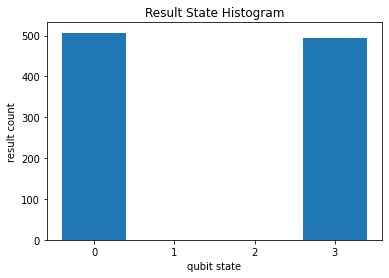

In [12]:
import matplotlib.pyplot as plt

cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

As visible some qubit states are empty which can be problematic when working with more qubits. To graph sparse sampled data, first get the Counts from your results with its histogram() function, and pass that to cirq.plot_state_histogram. By collecting the results into counts, all the qubit states that were never seen are ignored.

Counter({0: 507, 3: 493})


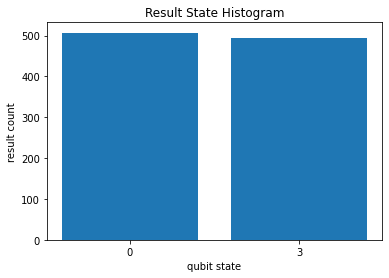

In [13]:
# histogram counts from result data structure
counts = samples.histogram(key='result')
print(counts)

# graph histogram counts instead of results
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

### **Using Parameter Sweeps**

For variational algorithms which vary parameters within circuit to optimize a cost function, Cirq circuits allow for gates to have symbols as free parameters within a circuit. For parameters, Cirq uses ```sympy``` to add ```sympy.Symbol``` as parameters to gates & opertions. 

After completion of circuit, possible values of each of these parameters can be filled with ```Sweep```.
- ```cirq.Points```: A list of manually specified values for one specific symbol as a sequence of floats.

- ```cirq.Linspace```: A linear sweep from a starting value to an ending value.

- ```cirq.ListSweep```: A list of manually specified values for several different symbols, specified as a list of dictionaries.

- ```cirq.Zip``` and ```cirq.Product```: Sweeps can be combined list-wise by zipping them together or through their Cartesian product.

A Parametrized circuit & sweep together can be run using simulator or other sampler by changing ```run()``` to ```run_sweep()``` & adding sweep as a parameter.

An example of sweeping an exponent of a X gate:

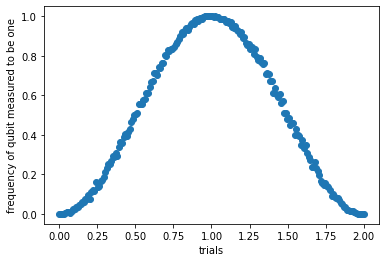

In [14]:
import sympy

# perform X gate with variable exponent
q = cirq.GridQubit(1, 1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'), cirq.measure(q, key='m'))

# sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# plot results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t', 'p', data={'t': x_data, 'p': y_data})
plt.xlabel("trials")
plt.ylabel("frequency of qubit measured to be one")
plt.show()

### **Unitary Matrices & decompositions**

Many quantum operations have unitary matrix representations. This matrix can be accessed by applying ```cirq.unitary```(operation) to that ```operation```. This can be applied to gates, operations, and circuits that support this protocol and will return the unitary matrix that represents the object.

In [15]:
print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


### **Decompositions**

A lot of gates can be decomposed into an equivalent circuit with simpler operations and gates, this process is called Decomposition & can be accomplished with ```cirq.decompose``` protocol.

A Hadamard H gate can be decomposed into X and Y gates:

In [16]:
print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(global_shift=-0.25).on(cirq.LineQubit(0))]


The 3-qubit Toffoli gate equivalent to a controlled-controlled-X gate is another example. Many devices do not support three qubit gates so they have to be decomposed into one and two qubit gates.

In [17]:
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))

0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


### **Transformers**

A transformer can take a circuit and modify (combining or modifying operations to make it more efficient and shorter), though a transformer can, in theory, do any sort of circuit manipulation.

The ```cirq.merge_single_qubit_gates_to_phxz``` transformer takes consecutive single-qubit operations and merges them into a single ```PhasedXZ``` operation.

In [18]:
q = cirq.GridQubit(1, 1)
c = cirq.Circuit(cirq.X(q) ** 0.25, cirq.Y(q) ** 0.25, cirq.Z(q) ** 0.25)
print(c)
c = cirq.merge_single_qubit_gates_to_phxz(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
(1, 1): ───PhXZ(a=0.304,x=0.333,z=0.142)───
